## Feature selection on detector regions for isolating changing features over multiple events


In [7]:
%%time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from scripts.tracks import get_tracks
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

N_events = 20

N_features = 13

regions = np.array([72,74,76,78,710,712,714])

feature_importances = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/feature_importances.pkl')
features = feature_importances.head(N_features)['feature'].values

tree_dfs = []

for i in range(0,N_events):
    
    if i < 10: 
        event_id = 'event00000100'+str(i)
    else: 
        event_id = 'event0000010'+str(i) 
    
    data = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/' + event_id + '_FE.pkl')
    N_tracks = 0
    data = get_tracks(data, N_tracks=N_tracks, drop_zero_weights=False, drop_zero_id=False, factorize_particle_id=False)
    data = data[np.insert(features, 0, ['hit_id','particle_id','vol_lay_concat'], axis=0)].copy()

    mm_scaler = MinMaxScaler(feature_range=(0,100))

    imps = []
    nhits = []
    scores = []
    roc_auc = []

    for reg in regions:
        data_reg = data[data['vol_lay_concat'] == reg]
        nhits.append(data_reg.shape[0])

        X = data_reg.iloc[:,3:]
        y = data_reg[['particle_id']].values.ravel()
        y = label_binarize(y, classes=list(np.unique(y)))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        dec_tree = DecisionTreeClassifier(random_state=0)
        dec_tree.fit(X_train, y_train)   
        dec_tree_preds = dec_tree.predict(X_test)
        roc_auc.append(roc_auc_score(y_test, dec_tree_preds, average='micro'))
        scores.append(dec_tree.score(X_test, y_test))

        imps_scaled = mm_scaler.fit_transform(dec_tree.feature_importances_.reshape(-1,1))
        imps_scaled = imps_scaled.reshape(1,-1).ravel()
        imps.append(imps_scaled) 


    dec_tree_df = pd.concat([pd.DataFrame(regions, columns=['region']), 
                             pd.DataFrame(np.array(imps), columns=features), 
                             pd.DataFrame(nhits, columns=['nhits']), 
                             pd.DataFrame(scores, columns=['score']),
                             pd.DataFrame(roc_auc, columns=['roc_auc'])], axis=1)

    tree_dfs.append(dec_tree_df)

CPU times: user 32min 10s, sys: 4.67 s, total: 32min 15s
Wall time: 32min 16s


### Viz standard devs of importances over multiple events

In [8]:
stds = [df.iloc[:,1:-3].std(axis=0) for df in tree_dfs]
stds_df = pd.concat(stds, axis=1)

stds_df['mean'] = stds_df.mean(axis=1)
stds_df = stds_df.sort_values('mean', ascending=False)

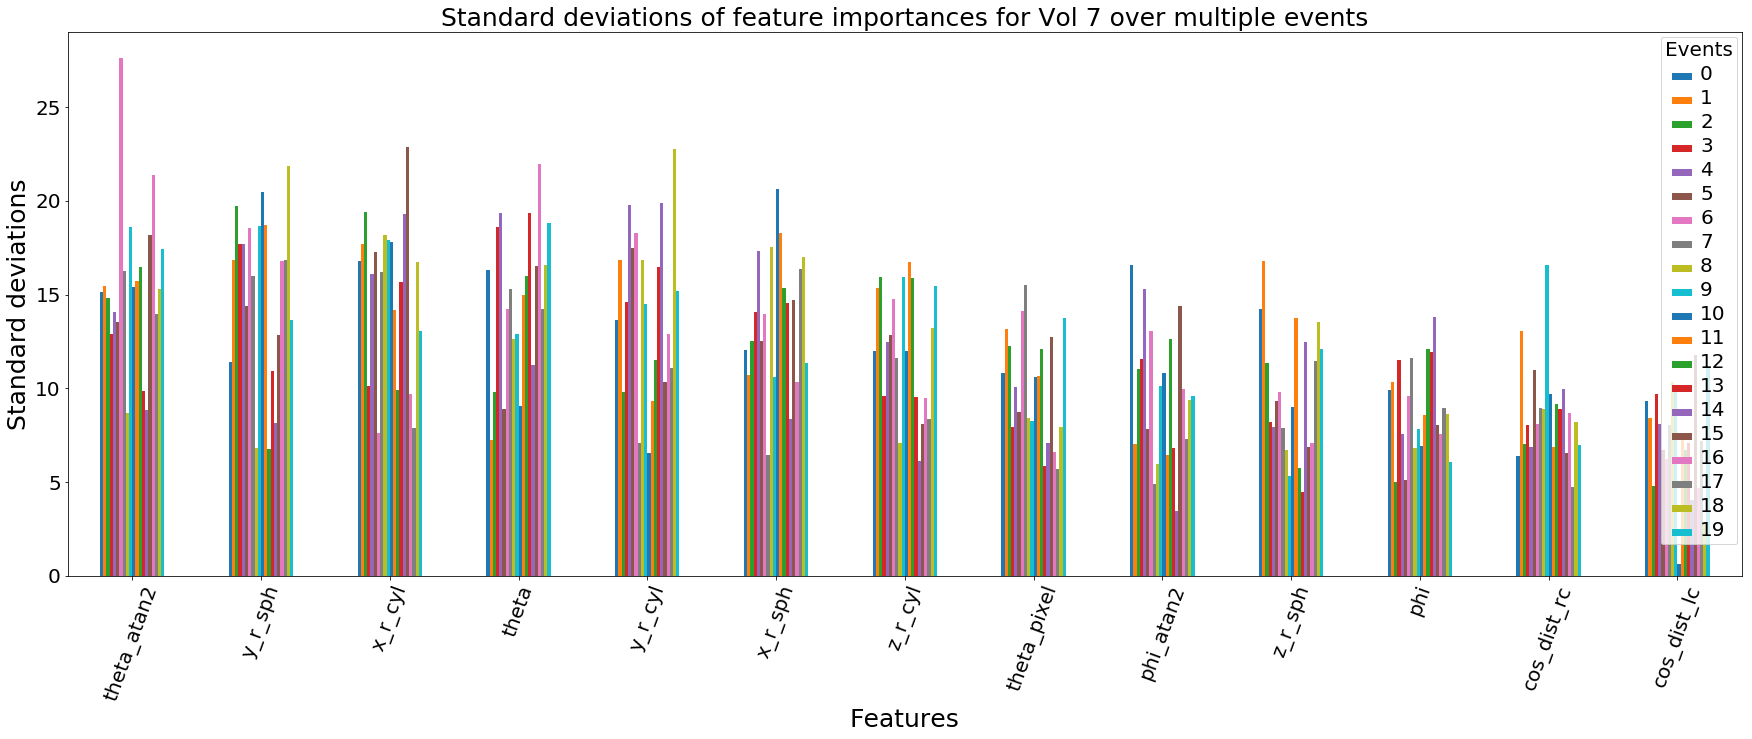

In [9]:
ax = stds_df.iloc[:,:-1].plot(kind='bar', figsize=(30,10))
ax.set_xlabel('Features', fontsize=25);
ax.set_ylabel('Standard deviations',fontsize=25);
ax.set_title('Standard deviations of feature importances for Vol 7 over multiple events', fontsize=25);
ax.tick_params(labelsize=20);
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);
plt.setp(ax.get_legend().get_texts(), fontsize='20');
plt.setp(ax.get_legend().get_title(), fontsize='20');
plt.setp(ax.get_legend(), title='Events');